Part-1 Visualizing the Data:
This notebook contains the code for visualizing the dance sequence from the input dance sequence files and choosing the appropriate parameters for the visualization.

In [2]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os

Point Labels and Skeleton lines to make lines between joints for the skeleton

In [3]:
point_labels = ['ARIEL','C7','CLAV','LANK','LBHD','LBSH','LBWT','LELB','LFHD','LFRM','LFSH','LFWT','LHEL','LIEL','LIHAND','LIWR','LKNE','LKNI','LMT1','LMT5','LOHAND','LOWR','LSHN','LTHI','LTOE','LUPA','MBWT','MFWT','RANK','RBHD','RBSH','RBWT','RELB','RFHD','RFRM','RFSH','RFWT','RHEL','RIEL','RIHAND','RIWR','RKNE','RKNI','RMT1','RMT5','ROHAND','ROWR','RSHN','RTHI','RTOE','RUPA','STRN','T10']

skeleton_lines = [
#     ( (start group), (end group) ),
    (('LHEL',), ('LTOE',)), # toe to heel
    (('RHEL',), ('RTOE',)),
    (('LMT1',), ('LMT5',)), # horizontal line across foot
    (('RMT1',), ('RMT5',)),
    (('LHEL',), ('LMT1',)), # heel to sides of feet
    (('LHEL',), ('LMT5',)),
    (('RHEL',), ('RMT1',)),
    (('RHEL',), ('RMT5',)),
    (('LTOE',), ('LMT1',)), # toe to sides of feet
    (('LTOE',), ('LMT5',)),
    (('RTOE',), ('RMT1',)),
    (('RTOE',), ('RMT5',)),
    (('LKNE',), ('LHEL',)), # heel to knee
    (('RKNE',), ('RHEL',)),
    (('LFWT',), ('RBWT',)), # connect pelvis
    (('RFWT',), ('LBWT',)),
    (('LFWT',), ('RFWT',)),
    (('LBWT',), ('RBWT',)),
    (('LFWT',), ('LBWT',)),
    (('RFWT',), ('RBWT',)),
    (('LFWT',), ('LTHI',)), # pelvis to thighs
    (('RFWT',), ('RTHI',)),
    (('LBWT',), ('LTHI',)),
    (('RBWT',), ('RTHI',)),
    (('LKNE',), ('LTHI',)),
    (('RKNE',), ('RTHI',)),
    (('CLAV',), ('LFSH',)), # clavicle to shoulders
    (('CLAV',), ('RFSH',)),
    (('STRN',), ('LFSH',)), # sternum & T10 (back sternum) to shoulders
    (('STRN',), ('RFSH',)),
    (('T10',), ('LFSH',)),
    (('T10',), ('RFSH',)),
    (('C7',), ('LBSH',)), # back clavicle to back shoulders
    (('C7',), ('RBSH',)),
    (('LFSH',), ('LBSH',)), # front shoulders to back shoulders
    (('RFSH',), ('RBSH',)),
    (('LFSH',), ('RBSH',)),
    (('RFSH',), ('LBSH',)),
    (('LFSH',), ('LUPA',),), # shoulders to upper arms
    (('RFSH',), ('RUPA',),),
    (('LBSH',), ('LUPA',),),
    (('RBSH',), ('RUPA',),),
    (('LIWR',), ('LIHAND',),), # wrist to hand
    (('RIWR',), ('RIHAND',),),
    (('LOWR',), ('LOHAND',),),
    (('ROWR',), ('ROHAND',),),
    (('LIWR',), ('LOWR',),), # across the wrist
    (('RIWR',), ('ROWR',),),
    (('LIHAND',), ('LOHAND',),), # across the palm
    (('RIHAND',), ('ROHAND',),),
    (('LFHD',), ('LBHD',)), # draw lines around circumference of the head
    (('LBHD',), ('RBHD',)),
    (('RBHD',), ('RFHD',)),
    (('RFHD',), ('LFHD',)),
    (('LFHD',), ('ARIEL',)), # connect circumference points to top of head
    (('LBHD',), ('ARIEL',)),
    (('RBHD',), ('ARIEL',)),
    (('RFHD',), ('ARIEL',)),
]


Loading the Dataset by excluding point of indices [26, 53]

In [4]:
class DanceDataset(Dataset):
        def __init__(self, root_dir, transform=None, exclude_points=[26, 53]):
            self.root_dir = root_dir
            self.transform = transform
            self.exclude_points = exclude_points
            self.files = os.listdir(root_dir)
            self.files = [f for f in self.files if f.endswith('.npy')]
            self.files = sorted(self.files)
            # No need to initialize self.labels here as we'll use the file names directly
    
        def __len__(self):
            return len(self.files)
    
        def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()
            file_name = self.files[idx]  # Get the file name
            file_path = os.path.join(self.root_dir, file_name)
            data = np.load(file_path)
    
            # Exclude specified points
            data = np.delete(data, self.exclude_points, axis=0)
    
            # Use the file name as the label (excluding the .npy extension)
            label = file_name[:-4]  # Remove the last 4 characters, which are ".npy"
    
            sample = {'data': data, 'label': label}
    
            if self.transform:
                sample = self.transform(sample)
    
            return sample

In [5]:
root_dir = 'data/'
dance_dataset = DanceDataset(root_dir)

In [6]:
dance_dataset[0]['data'].shape

(53, 10925, 3)

In [7]:
dance_dataset[0]['label']

'mariel_betternot_and_retrograde'

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_sequences(data, start_timestep, end_timestep, sequence_limit, step_size=1, joint_labels=None, skeleton_lines=None, elev=10, azim=90, scale_factor=1):
    """
    Plots the 3D positions of joints for a sequence of timesteps within a given range, creating a new figure for each sequence when the range exceeds the limit.

    Parameters:
    - data: numpy array of shape (#joints, #timesteps, 3)
    - start_timestep: int, the starting timestep of the sequence to plot
    - end_timestep: int, the ending timestep of the sequence to plot
    - sequence_limit: int, the maximum number of timesteps to plot in one figure
    - step_size: int, the number of timesteps to skip when plotting to reduce clutter
    - joint_labels: list of str, optional labels for each joint
    - skeleton_lines: list of tuples, each tuple contains two joint labels that form a line
    - elev: Elevation angle in the z plane for viewing. Default is 10.
    - azim: Azimuth angle in the x,y plane for viewing. Default is 90.
    - scale_factor: float, factor to scale the axes limits. Default is 2.
    """
    
    total_timesteps = (end_timestep - start_timestep) // step_size
    for current_start_idx in range(start_timestep, end_timestep, sequence_limit * step_size):
        current_end_idx = min(current_start_idx + (sequence_limit * step_size), end_timestep + 1, data.shape[1])
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        
        for t_idx in range(current_start_idx, current_end_idx, step_size):
            t = min(t_idx, data.shape[1] - 1)
            positions = data[:, t, :].copy()
            positions[:, 2] *= -1  # Invert the z-axis
            # Adjust the x-axis offset for each timestep within the individual plot
            positions[:, 0] += ((t_idx - current_start_idx) // step_size) * scale_factor * 0.5
            
            for i, (x, y, z) in enumerate(positions):
                ax.scatter(x, y, z, label=joint_labels[i] if joint_labels and t_idx == current_start_idx else None)
            
            if skeleton_lines and joint_labels:
                for line in skeleton_lines:
                    start, end = line[0][0], line[1][0]
                    if start in joint_labels and end in joint_labels:
                        start_idx, end_idx = joint_labels.index(start), joint_labels.index(end)
                        start_pos, end_pos = positions[start_idx], positions[end_idx]
                        ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], [start_pos[2], end_pos[2]], 'blue')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'3D Joint Sequences from Timestep {current_start_idx} to {current_end_idx - 1}')
        ax.view_init(elev=elev, azim=azim)
        
        plt.tight_layout()
        plt.show()


This is the plotting of dance sequence with our given parameters.

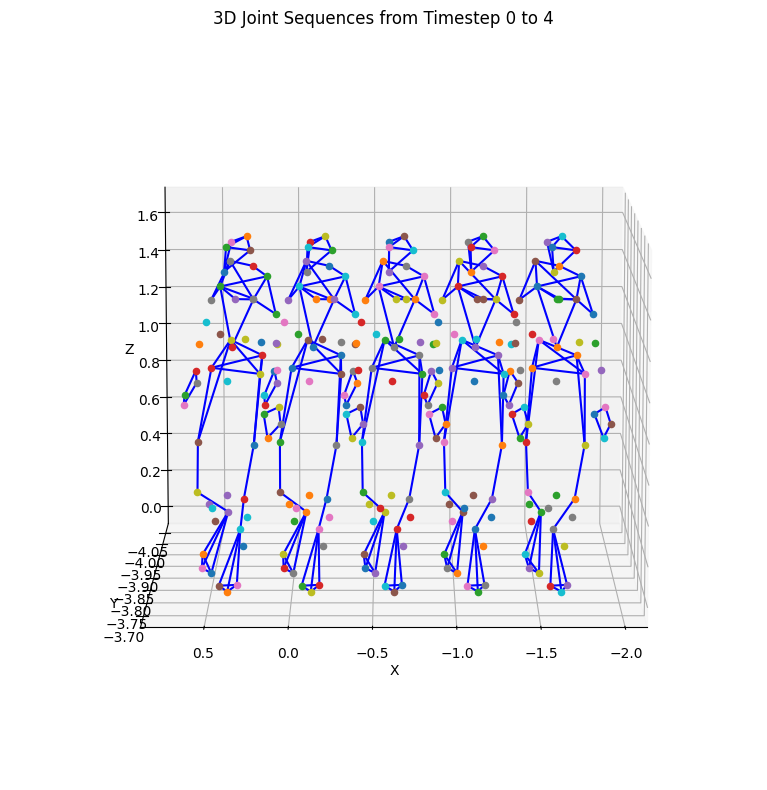

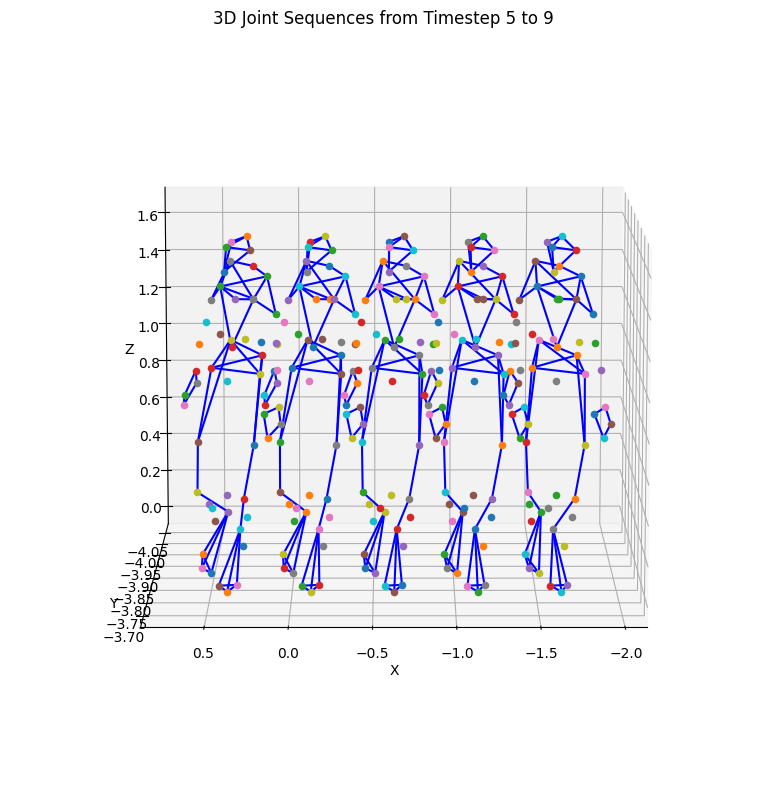

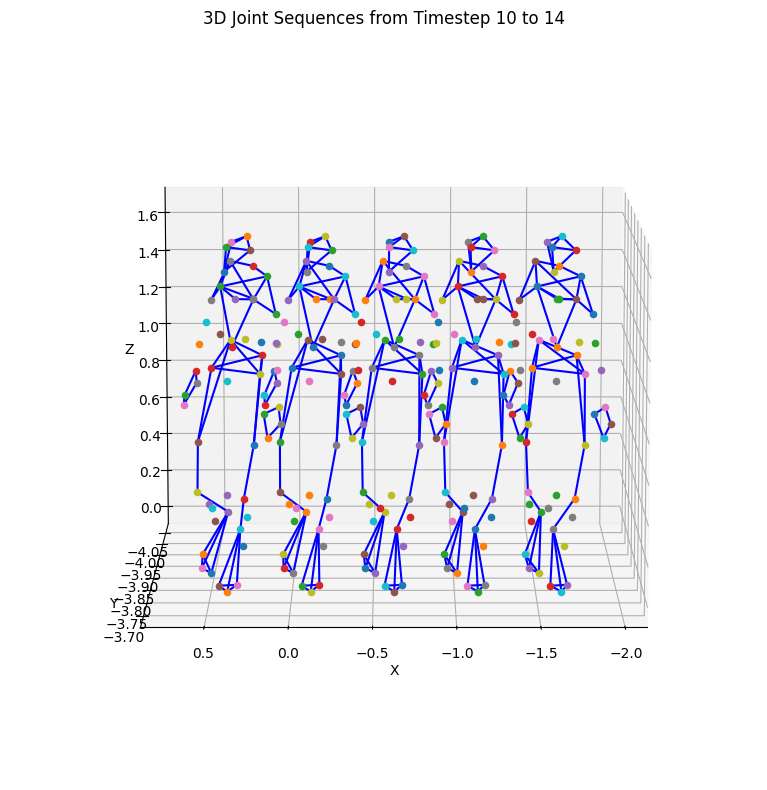

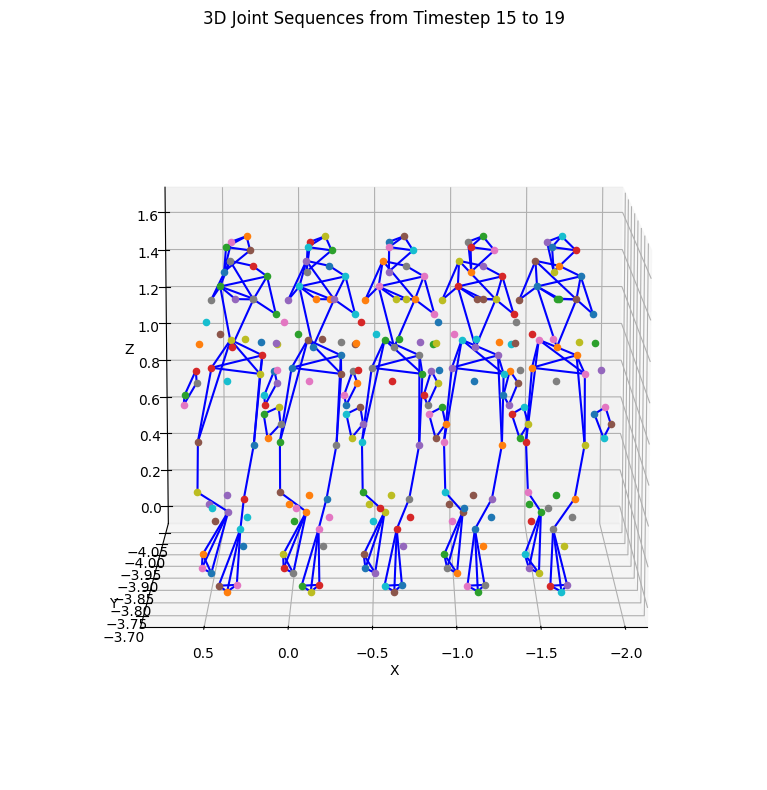

In [9]:
sample = dance_dataset[2]['data']  # Get the first sample's data
plot_sequences(sample, 0, 20 , 5 , joint_labels=point_labels, skeleton_lines=skeleton_lines)